# ML: Supervised algorithm - NLP - Sentiment Analysis

## Introduction

From a dataset of tweets labelled according to whether they correspond to good or bad news, we will generate a predictive model that allows us to perform this classification using VADER.

## 1. Import libraries

In [173]:
import numpy as np 
import pandas as pd 

# Text processing libraries
import re
import string
import nltk
nltk.download('stopwords') # bajar la primera vez
from nltk.corpus import stopwords

# sklearn 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,balanced_accuracy_score,roc_curve, auc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Lime for result explanation
from lime import lime_text
from lime.lime_text import LimeTextExplainer 
from sklearn.pipeline import make_pipeline

# VADER model
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load datasets

We are going to work with a set of tweets that are related to disasters. The file can be downloaded "tweet_disaster.csv".

Load the data with pandas:

In [174]:
filename = 'tweet_disasters.csv'
train = pd.read_csv(filename)

In [175]:
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [176]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Eventually, we display on screen the texts for those cases that are identified as catastrophes.

In [177]:
train.text[train.target == 1]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

## 3. Dataset analysis

The first step of our EDA is to analyse the number of nulls by adding up the number of records with a null value for each column. Notice that the number of nulls in the location column is very high.

In [178]:
#Missing values in training set
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Let's remove the location column, we don't need it:

In [179]:
train=train.drop(columns=["location"])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


The next step is to explore the target variable in more detail. We can follow 2 strategies: do a count with the value_counts() function or get a bar chart:

In [180]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

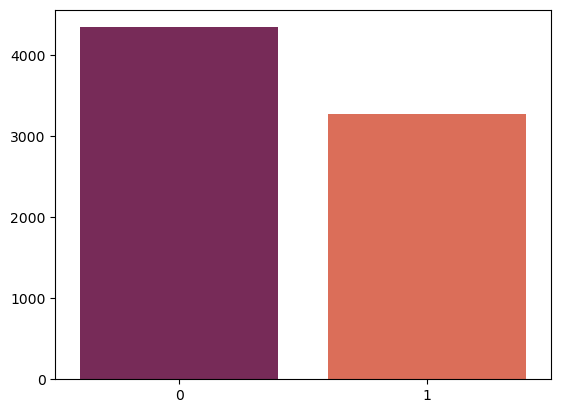

In [181]:
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts().values, palette='rocket')

In [182]:
train['target'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [183]:
train['target'].value_counts().values

array([4342, 3271], dtype=int64)

Analyse some examples of tweets that correspond to disasters:

In [184]:
# Disaster tweets
disaster_tweets = train[train['target']==1]['text']

print(disaster_tweets.values[2])
print(disaster_tweets.values[23])

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg


In [185]:
# Not disaster tweets
non_disaster_tweets = train[train['target']==0]['text']
print(non_disaster_tweets.values[2])
print(non_disaster_tweets.values[23])

Summer is lovely
Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??


Finally, let's analyse the keyword variable. We can see that it has 221 unique values and that they are distributed as follows:

In [186]:
train['keyword'].nunique()

221

In [187]:
train['keyword'].value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: keyword, dtype: int64

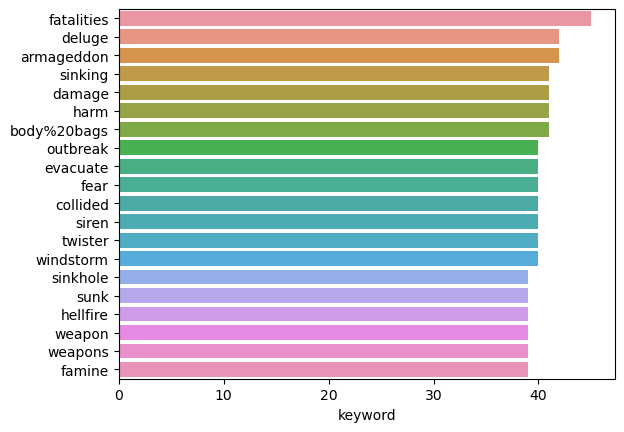

In [188]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20],
            orient='h')

Does this variable contain the word disaster and can there be any relationship between this keyword and the value of the target variable we want to predict?

In [189]:
train.loc[train['text'].str.contains('disaster')][['text','target']]

,text,target
6,#flood #disaster Heavy rain causes flash flood...,1
622,Volunteers needed to participate in Emergency ...,1
1162,Australia's Ashes disaster - how the collapse ...,1
1182,Australia's Ashes disaster - how the collapse ...,1
1558,Emergency responders prepare for chemical disa...,1
...,...,...
7041,Obama Declares Disaster for Typhoon-Devastated...,1
7052,#ABCNews Obama Declares Disaster for Typhoon-D...,1
7053,Obama Declares Disaster for Typhoon-Devastated...,1
7368,NEMA Ekiti distributed relief materials to aff...,1


In [190]:
train.loc[train['text'].str.contains('disaster')].target.value_counts()
#parece que hay cierta correlación

1    77
0    32
Name: target, dtype: int64

## 4. Pre-processing and cleaning of texts

We are going to apply a function to each of the records that allows us to clean up the content of the tweets:

* Remove the text that appears in square brackets.
* Remove URLs
* Remove punctuation marks and line breaks
* Remove numbers

Save the result in the variable text2 and compare the result.

In [191]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links, remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    text = re.sub('\n', '', text) #remove newlines
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text

In [192]:
# Apply the cleaning function
train['text2'] = train['text'].apply(lambda x: clean_text(x))

In [193]:
train.head(30)[['text', 'text2']]

,text,text2
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed in bo...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,im on top of the hill and i can see a fire in ...
8,There's an emergency evacuation happening now ...,theres an emergency evacuation happening now i...
9,I'm afraid that the tornado is coming to our a...,im afraid that the tornado is coming to our area


To compare the words that appear in the two cases we have to separate our data into two different sets:

In [194]:
non_disaster_tweets = train[train['target']==0]['text2']
disaster_tweets = train[train['target']==1]['text2']

Visualise both word clouds side by side with the subplot command:

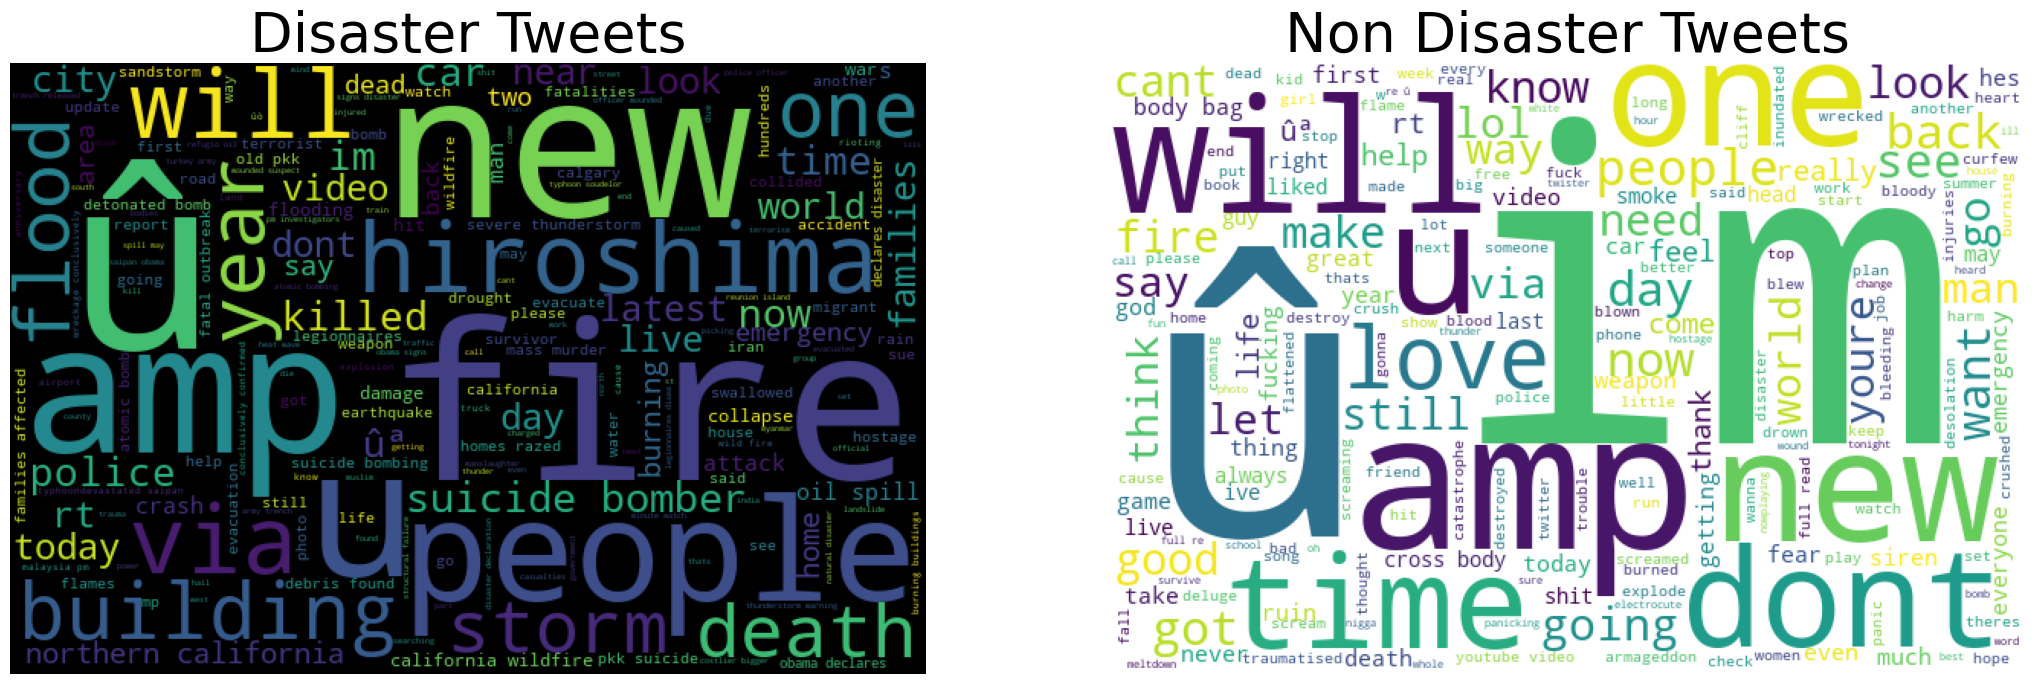

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='black',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

There are some words that don't seem to provide much information such as 'dont' or 'amp', so we are going to update the list of stopwords with them:

In [196]:
#Update the list of stopwords with those we have identified in the wordclouds that are of no interest to us (some are the result of errors)
stop_words = set(stopwords.words('english'))
stop_words.update(["û", "u","dont", "im", "one", "amp", "new"])

To improve the word clouds we will further "normalise" our data:

* We get the word tokens.
* We remove punctuation marks and stopwords.

In [197]:
# función de preprocesado
def text_preprocessing(text):
    # 1. Data cleaning on the text variable
    nopunc = clean_text(text)
    
    # 2. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = tokenizer.tokenize(nopunc)
    
    # 3. Remove stopwords
    remove_stopwords = [w for w in nopunc if w not in stop_words]
    
    # 4. Join the information
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [198]:
train['text3'] = train['text'].apply(lambda x : text_preprocessing(x))

Update the word clouds:

In [199]:
non_disaster_tweets = train[train['target']==0]['text3']
disaster_tweets = train[train['target']==1]['text3']

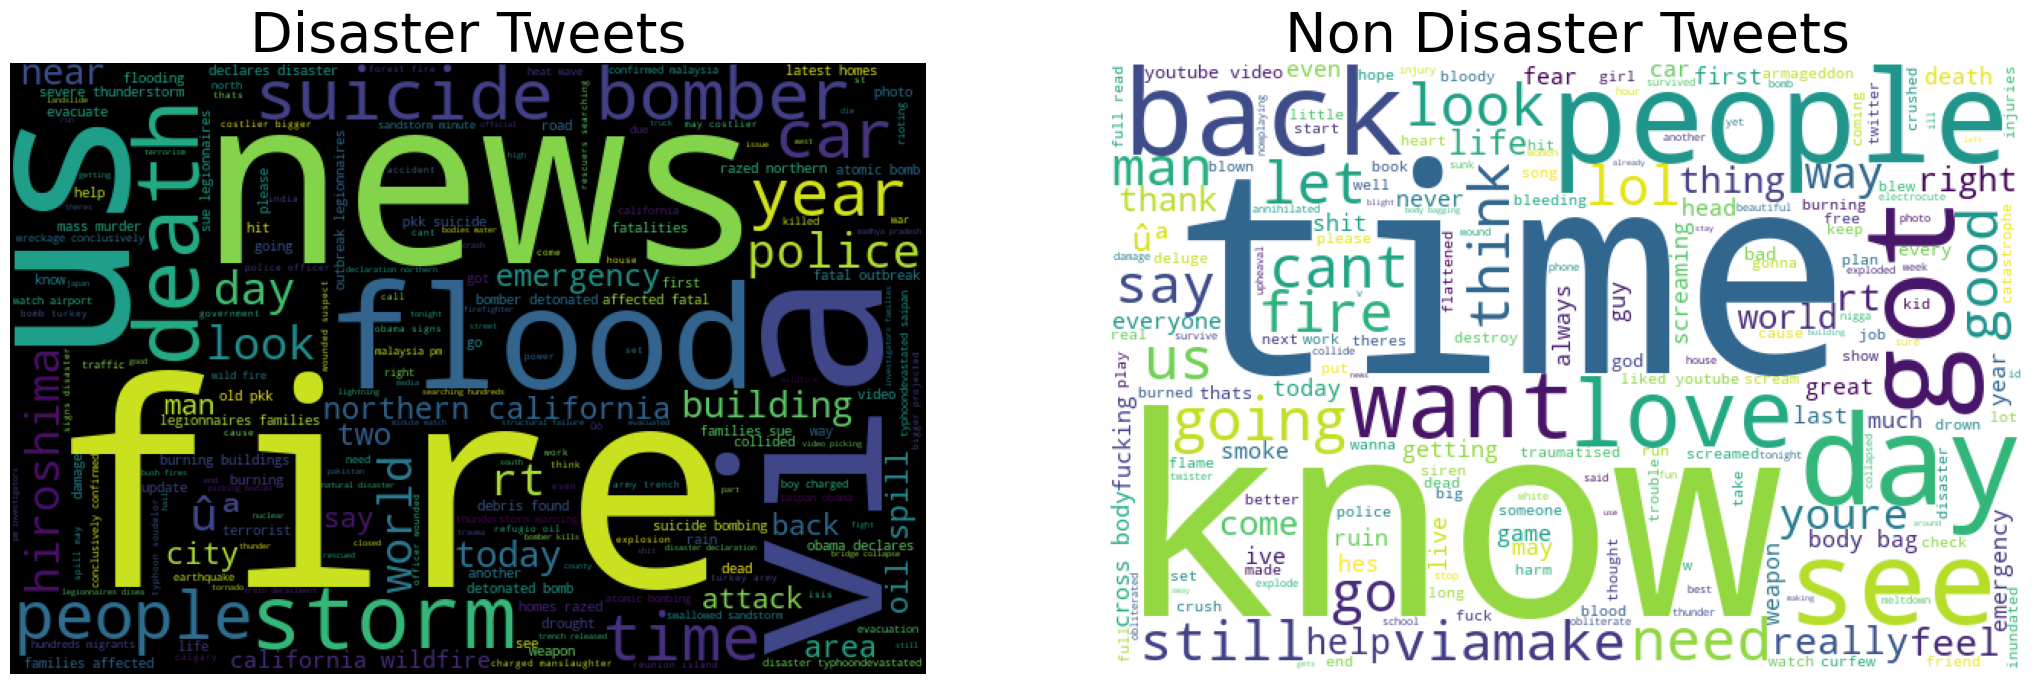

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='black',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

# 7. Build model

To generate the TF-IDF representation we apply limits to obtain relevant words and set the maximum number of components to 1500.

In [201]:
tfidf = TfidfVectorizer(max_features=1500,
                        min_df=2,
                        max_df=0.5,
                        ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(train['text3'])

train_tfidf

<7613x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 41342 stored elements in Compressed Sparse Row format>

In [202]:
train_tfidf.toarray().shape

(7613, 1500)

Generate 2 models: with Naive Bayes and a Logistic Regression.

First we will separate the data into data to train, X, and variable to predict, y. We generate the train and test sets.

In [203]:
y = train['target']
X = train_tfidf

In [204]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=42)

### Naive Bayes:

In [205]:
clf_NB = MultinomialNB()

NB = clf_NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

In [206]:
print("Accuracy: "+str(accuracy_score(y_test,y_pred)))
print("Precision: "+str(precision_score(y_test,y_pred)))
print("Recall: "+str(recall_score(y_test,y_pred)))
print("F1: "+str(f1_score(y_test,y_pred)))

Accuracy: 0.7859019264448336
Precision: 0.8093385214007782
Recall: 0.6459627329192547
F1: 0.7184801381692573


### Logistic Regression:

In [207]:
clf_logistic = LogisticRegression()
logistic = clf_logistic.fit(X_train, y_train)
y_pred_logistic = logistic.predict(X_test)

In [208]:
y_pred_logistic

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [209]:
print("Accuracy: "+str(accuracy_score(y_test,y_pred_logistic)))
print("Precision: "+str(precision_score(y_test,y_pred_logistic)))
print("Recall: "+str(recall_score(y_test,y_pred_logistic)))
print("F1: "+str(f1_score(y_test,y_pred_logistic)))

Accuracy: 0.7907180385288967
Precision: 0.7990196078431373
Recall: 0.6749482401656315
F1: 0.7317620650953984


To improve predictive quality? Some options are: improving the cleanliness of tweets, using other types of models, doing grid search to improve hyperparameters.

### Lime explanation:

First we are going to reset the index of the dataframe to make it easier to work with. It is not uncommon that in long processes the dataframe indexes become a bit chaotic, therefore, it can be good to reset them but always bearing in mind that the values along the process can change.

In [210]:
disaster_tweets.reset_index(inplace=True, drop=True)
disaster_tweets

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
3266    two giant cranes holding bridge collapse nearb...
3267    ariaahrary thetawniest control wild fires cali...
3268                                       volcano hawaii
3269    police investigating ebike collided car little...
3270    latest homes razed northern california wildfir...
Name: text3, Length: 3271, dtype: object

In order to apply the Lime library we are going to create a script.

In [211]:
vect=tfidf
classifier = logistic
c = make_pipeline(vect, classifier)

y_pred_prob = classifier.predict_proba(X_test)[:, 1]
mystring = disaster_tweets[58] #Print a string from test instance 
print(mystring)
print(c.predict_proba([mystring])) #Prediction is 1, i.e., disaster
class_names = ["not disaster", "disaster"]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_instance=mystring, 
                                 classifier_fn=c.predict_proba, 
                                 num_features=10)
exp.as_list()

horrible accident man died wings airplane
[[0.17 0.83]]


[('accident', 0.1526129371463432),
 ('horrible', 0.08040628053266168),
 ('airplane', 0.06629507468194458),
 ('died', 0.06028271011646905),
 ('man', -0.05182705487722109),
 ('wings', 0.004228481266661367)]

Finally, show the graph that will allow us to explain the results to a less technical audience.

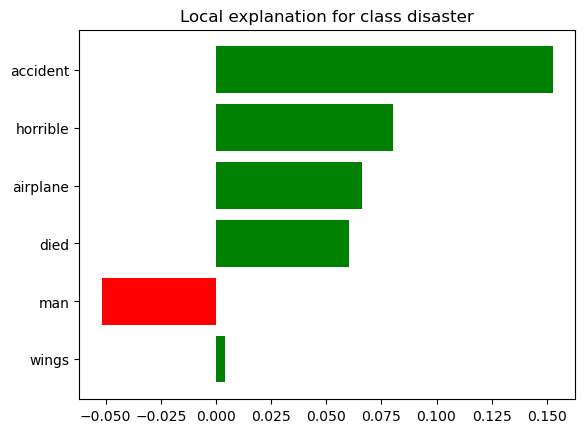

In [212]:
fig = exp.as_pyplot_figure()

### VADER:

Let's use another dataset for this model.

In [213]:
train_path = 'tweets_SentimentAnalysis.csv'

data = pd.read_csv(train_path)
data.head()

,Unnamed: 0,ItemID,Sentiment,SentimentText
0,0,1,0,is so sad for my APL frie...
1,1,2,0,I missed the New Moon trail...
2,2,3,1,omg its already 7:30 :O
3,3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,4,5,0,i think mi bf is cheating on me!!! ...


In [214]:
data.shape

(10000, 4)

Eliminate the first columns and quickly check for the presence or absence of nulls.

In [215]:
data.drop(columns=['Unnamed: 0', 'ItemID'], inplace=True)
data.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

With VADER we have to be very careful with the cleaning because, is sensitive to emoticons, upper/lower case, etc. We are simply not going to apply any cleaning and we are going to apply VADER directly on the data and return 4 scores: negative, neutral, positive and composite.

In [216]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['neg'], score['neu'], score['pos'], score['compound']

We apply it to some test sentences to check how the function works:

In [217]:
sentiment_analyzer_scores('I love ramen')

(0.0, 0.323, 0.677, 0.6369)

In [218]:
sentiment_analyzer_scores('Joan is late again. She is so annoying.')

(0.333, 0.667, 0.0, -0.541)

In [219]:
data_copy=data.copy()
data_copy[['Negative_VADER', 'Neutral_VADER', 'Positive_VADER', 'Compound_VADER']]=data_copy['SentimentText'].apply(sentiment_analyzer_scores).apply(pd.Series)
data_copy.head(20)

,Sentiment,SentimentText,Negative_VADER,Neutral_VADER,Positive_VADER,Compound_VADER
0,0,is so sad for my APL frie...,0.293,0.431,0.276,-0.0498
1,0,I missed the New Moon trail...,0.306,0.694,0.000,-0.2960
2,1,omg its already 7:30 :O,0.348,0.652,0.000,-0.2808
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,0.114,0.886,0.000,-0.4767
4,0,i think mi bf is cheating on me!!! ...,0.359,0.641,0.000,-0.6679
5,0,or i just worry too much?,0.367,0.633,0.000,-0.4404
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,0.000,1.000,0.000,0.0000
7,0,Sunny Again Work Tomorrow :-| ...,0.179,0.526,0.295,0.2732
8,1,handed in my uniform today . i miss you ...,0.151,0.849,0.000,-0.1531
9,1,hmmmm.... i wonder how she my number @-),0.000,0.843,0.157,0.0772


In [220]:
data_copy['SentimentText'].apply(sentiment_analyzer_scores).apply(pd.Series)

,0,1,2,3
0,0.293,0.431,0.276,-0.0498
1,0.306,0.694,0.000,-0.2960
2,0.348,0.652,0.000,-0.2808
3,0.114,0.886,0.000,-0.4767
4,0.359,0.641,0.000,-0.6679
...,...,...,...,...
9995,0.066,0.795,0.139,0.2584
9996,0.000,1.000,0.000,0.0000
9997,0.000,0.642,0.358,0.8725
9998,0.198,0.802,0.000,-0.4047


Now the goal is to try to create a sentiment classification model, the Sentiment variable, with these new variables that we have generated. To do this we have to eliminate the output variable from our model and we separate the data into input, X, and output, y.

In [221]:
data_copy.drop(columns='SentimentText', inplace=True)
X_data=data_copy.drop(columns='Sentiment')
X = X_data
y = data_copy['Sentiment']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print(len(X_train))
print(len(X_test))

print("n_samples: {}; n_features: {}".format(X_train.shape[0],X_train.shape[1]))

7000
3000
n_samples: 7000; n_features: 4


We create a dictionary with the potential parameters of our classification model. Note that for each parameter we have several options. 

In [223]:
param_dict = {
  "n_estimators": [100,200,300],
  "min_samples_leaf": [1,2,4],
  "min_samples_split": [2,5,10],
  "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)]
}

En el proceso de validación cruzada vamos a probar los distintos pares de parámetros para seleccionar la mejor opción.

In [224]:
rf = RandomForestClassifier(random_state=42)
rand_forest = RandomizedSearchCV(estimator = rf, param_distributions = param_dict, n_iter = 60, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rand_forest.fit(X_train, y_train)
rand_forest.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10}

Finally, we use the best parameters obtained from the cross-validation to train the final model on which we will obtain different measures of the quality of the model.

In [225]:
rand_forest_final = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=10,random_state=42)
rand_forest_final.fit(X_train, y_train)
RF_preds = rand_forest_final.predict(X_test)

In [226]:
print("Accuracy: "+str(accuracy_score(y_test,RF_preds)))
print("Precision: "+str(precision_score(y_test,RF_preds)))
print("Recall: "+str(recall_score(y_test,RF_preds)))
print("F1: "+str(f1_score(y_test,RF_preds)))

Accuracy: 0.6986666666666667
Precision: 0.7046511627906977
Recall: 0.482484076433121
F1: 0.5727788279773157
